## **Veritas Vigil**

In [1]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Set of English stopwords
stop_words = set(stopwords.words('english'))

class CustomTokenizer:
    def __init__(self):
        # Patterns for emoticons, contractions, words, and punctuation
        self.emoticon_pattern = r'[:;=8][\-o\*]?[)D\(\]/\\OpP]'
        self.contraction_pattern = r"\b\w+'\w+\b"
        self.word_pattern = r"\b\w+\b"
        self.punct_pattern = r"[!\"#$%&'()*+,\-./:;<=>?@[\\]^_`{|}~]"
        # Combine all patterns
        self.pattern = re.compile(
            f"{self.emoticon_pattern}|{self.contraction_pattern}|{self.word_pattern}|{self.punct_pattern}",
            re.IGNORECASE
        )
        # Pattern for repeated characters (3 or more)
        self.repeat_pattern = re.compile(r'(.)\1{2,}', re.IGNORECASE)

    def normalize_repeats(self, word):
        def repl(match):
            char = match.group(1)
            count = len(match.group(0))
            return f"{char} <REPEAT:{count}>"
        return self.repeat_pattern.sub(repl, word)

    def tokenize(self, text):
        text = text.lower()
        tokens = self.pattern.findall(text)
        # Normalize repeated characters in each token
        norm_tokens = []
        for token in tokens:
            norm_token = self.normalize_repeats(token)
            # Split if <REPEAT:> is appended
            if "<REPEAT:" in norm_token:
                parts = norm_token.split()
                norm_tokens.extend(parts)
            else:
                norm_tokens.append(norm_token)
        return norm_tokens

    def remove_stopwords(self, tokens):
        # Filter out stopwords from token list
        return [token for token in tokens if token not in stop_words]

    def pos_tag(self, tokens):
        tags = []
        for token in tokens:
            # Handle contractions first
            if re.match(r"\w+('t|'ll|'re|'ve|'d|'s|'m)$", token):
                tags.append((token, 'VERB'))
            # Then check other patterns
            elif re.match(r'.+(ing|ed)$', token):
                tags.append((token, 'VERB'))
            elif re.match(r'.+y$', token):
                tags.append((token, 'ADJ'))
            elif token in [':)', ':(', '!', '?', '.', ',', ';', ':']:
                tags.append((token, 'OTHER'))
            else:
                tags.append((token, 'NOUN'))
        return tags

# Usage:
tokenizer = CustomTokenizer()
text = "Sooooo happy!!! Can't wait :) #excited"

# Tokenize the text
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

# Remove stopwords
filtered_tokens = tokenizer.remove_stopwords(tokens)
print("Filtered Tokens:", filtered_tokens)

# POS tag the filtered tokens
tags = tokenizer.pos_tag(filtered_tokens)
print("POS Tags:", tags)


Tokens: ['so', '<REPEAT:5>', 'happy', "can't", 'wait', ':)', 'excited']
Filtered Tokens: ['<REPEAT:5>', 'happy', "can't", 'wait', ':)', 'excited']
POS Tags: [('<REPEAT:5>', 'NOUN'), ('happy', 'ADJ'), ("can't", 'VERB'), ('wait', 'NOUN'), (':)', 'OTHER'), ('excited', 'VERB')]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
class RuleBasedLemmatizer:
    def __init__(self):
        # Suffix rules for verbs, nouns, adjectives
        self.verb_suffixes = ['ing', 'ed', 's']
        self.noun_suffixes = ['ies', 'es', 's']
        self.adj_suffixes = ['est', 'er']

    def lemmatize(self, token, pos_tag):
        if pos_tag == 'VERB':
            return self.lemmatize_verb(token)
        elif pos_tag == 'NOUN':
            return self.lemmatize_noun(token)
        elif pos_tag == 'ADJ':
            return self.lemmatize_adj(token)
        else:
            return token

    def lemmatize_verb(self, word):
        # Remove 'ing' (present participle), handle double consonant (e.g., running → run)
        if word.endswith('ing') and len(word) > 4:
            if len(word) > 5 and word[-4] == word[-5]:
                return word[:-4]
            else:
                return word[:-3]
        # Remove 'ed' (past tense)
        elif word.endswith('ed') and len(word) > 3:
            return word[:-2]
        # Remove 's' (third person singular)
        elif word.endswith('s') and len(word) > 3:
            return word[:-1]
        else:
            return word

    def lemmatize_noun(self, word):
        # Plural to singular
        if word.endswith('ies') and len(word) > 4:
            return word[:-3] + 'y'
        elif word.endswith('es') and len(word) > 3:
            return word[:-2]
        elif word.endswith('s') and len(word) > 3:
            return word[:-1]
        else:
            return word

    def lemmatize_adj(self, word):
        # Comparative and superlative
        if word.endswith('est') and len(word) > 4:
            return word[:-3]
        elif word.endswith('er') and len(word) > 3:
            return word[:-2]
        else:
            return word

# Example usage
lemmatizer = RuleBasedLemmatizer()
sample_tokens = [
    ('running', 'VERB'), ('walked', 'VERB'), ('runs', 'VERB'),
    ('babies', 'NOUN'), ('boxes', 'NOUN'), ('cats', 'NOUN'),
    ('biggest', 'ADJ'), ('bigger', 'ADJ'), ('happy', 'ADJ'),
    ('dogs', 'NOUN'), ('played', 'VERB'), ('excited', 'ADJ')
]
lemmatized = [(token, pos, lemmatizer.lemmatize(token, pos)) for token, pos in sample_tokens]
print(lemmatized)


[('running', 'VERB', 'run'), ('walked', 'VERB', 'walk'), ('runs', 'VERB', 'run'), ('babies', 'NOUN', 'baby'), ('boxes', 'NOUN', 'box'), ('cats', 'NOUN', 'cat'), ('biggest', 'ADJ', 'bigg'), ('bigger', 'ADJ', 'bigg'), ('happy', 'ADJ', 'happy'), ('dogs', 'NOUN', 'dog'), ('played', 'VERB', 'play'), ('excited', 'ADJ', 'excited')]


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
fake_df = pd.read_csv('/content/drive/MyDrive/veritas/Fake.csv')
true_df = pd.read_csv('/content/drive/MyDrive/veritas/True.csv')

In [5]:
fake_df['label'] = 0  # 0 for fake
true_df['label'] = 1  # 1 for true

# Combine into one DataFrame
df = pd.concat([fake_df, true_df], ignore_index=True)

df['combined_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
corpus = df['combined_text'].tolist()

# Initialize your custom components
tokenizer = CustomTokenizer()
lemmatizer = RuleBasedLemmatizer()

def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

processed_corpus = []
for doc in corpus:
    # Tokenize
    tokens = tokenizer.tokenize(doc)
    # Remove stopwords
    tokens = remove_stopwords(tokens)
    # POS tag
    tags = tokenizer.pos_tag(tokens)
    # Lemmatize using POS tags
    lemmas = [lemmatizer.lemmatize(token, pos) for token, pos in tags]
    # Join lemmas into a string
    processed_corpus.append(" ".join(lemmas))

# Example output of first document
print(processed_corpus[0])


donald trump send embarras new year eve message disturb donald trump wish american happy new year leave instead give shout enemy hater dishonest fake new media former reality show star one job country rapidly grow stronger smarter want wish friend supporter enemy hater even dishonest fake new media happy healthy new year president angry pant tweet 2018 great year america country rapidly grow stronger smarter want wish friend supporter enemy hater even dishonest fake new media happy healthy new year 2018 great year america donald j trump realdonaldtrump december 31 2017trump tweet went wel <REPEAT:3> expect kind president send new year greet like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizen happy new year bishop talbert swan talbertswan december 31 2017no one lik calvin calvinstowell december 31 2017your impeachment would make 2018 great year america also accept regain control congres miranda yaver mirandayaver december

## Applying Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# --- Bag of Words with Efficient Settings ---
def space_tokenizer(text):
    # Only keep tokens that have digits or are very short
    return [tok for tok in text.split() if re.fullmatch(r'[a-zA-Z]+', tok) and len(tok) > 2]

vectorizer = CountVectorizer(
    tokenizer=space_tokenizer,
    max_features=5000,  # Limits vocabulary size (tune as needed)
    min_df=5            # Ignores words that appear in fewer than 5 docs
)
X = vectorizer.fit_transform(processed_corpus)
feature_names = vectorizer.get_feature_names_out()

print("Unique Word List (first 10):", feature_names[:10])
print("BoW matrix shape:", X.shape)
# DO NOT call X.toarray() unless you have a small dataset!


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Unique Word List (first 10): ['abadi' 'abandon' 'abba' 'abc' 'abdullah' 'abe' 'abedin' 'abid' 'ability'
 'able']
BoW matrix shape: (44898, 5000)


In [7]:
y = df['label'].values
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize models
nb_clf = MultinomialNB()
svm_clf = LinearSVC()

# Train
nb_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

# Predict
nb_preds = nb_clf.predict(X_test)
svm_preds = svm_clf.predict(X_test)


## Token Frequency and Word Cloud

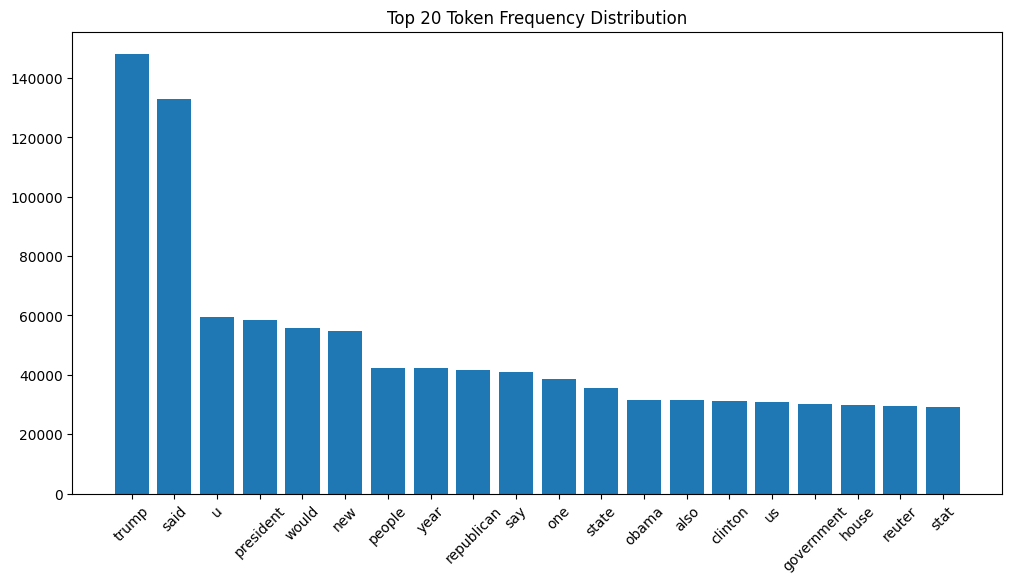

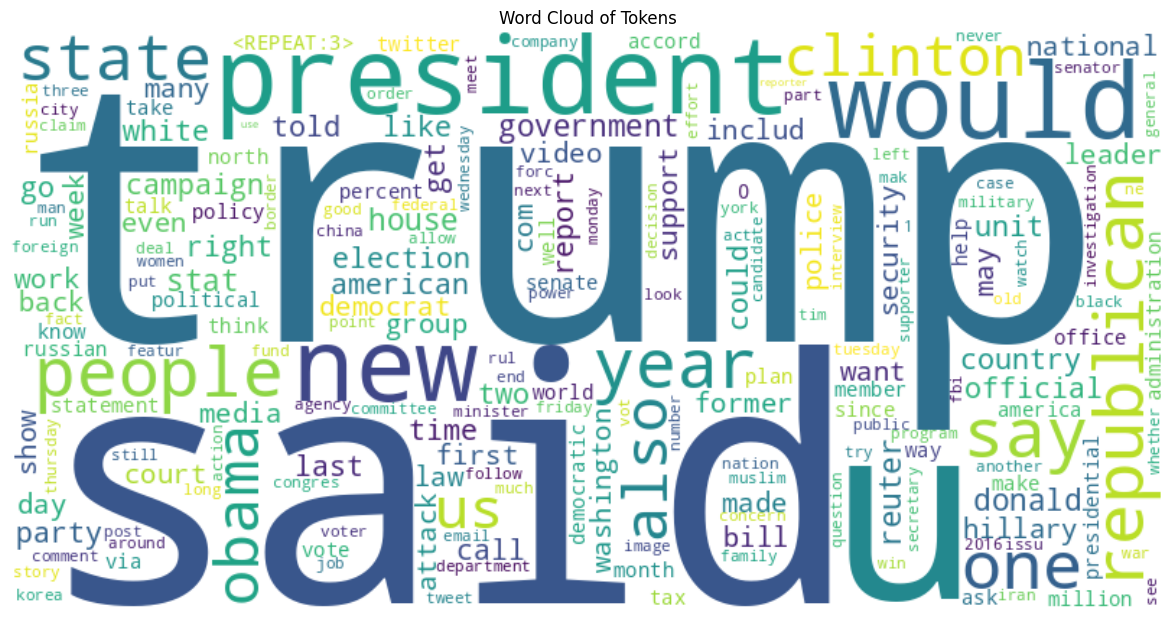

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_tokens = [tok for doc in processed_corpus for tok in doc.split()]
token_counts = Counter(all_tokens)

# Bar chart
most_common_tokens = token_counts.most_common(20)
words, counts = zip(*most_common_tokens)
plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.title('Top 20 Token Frequency Distribution')
plt.xticks(rotation=45)
plt.show()

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counts)
plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tokens')
plt.show()


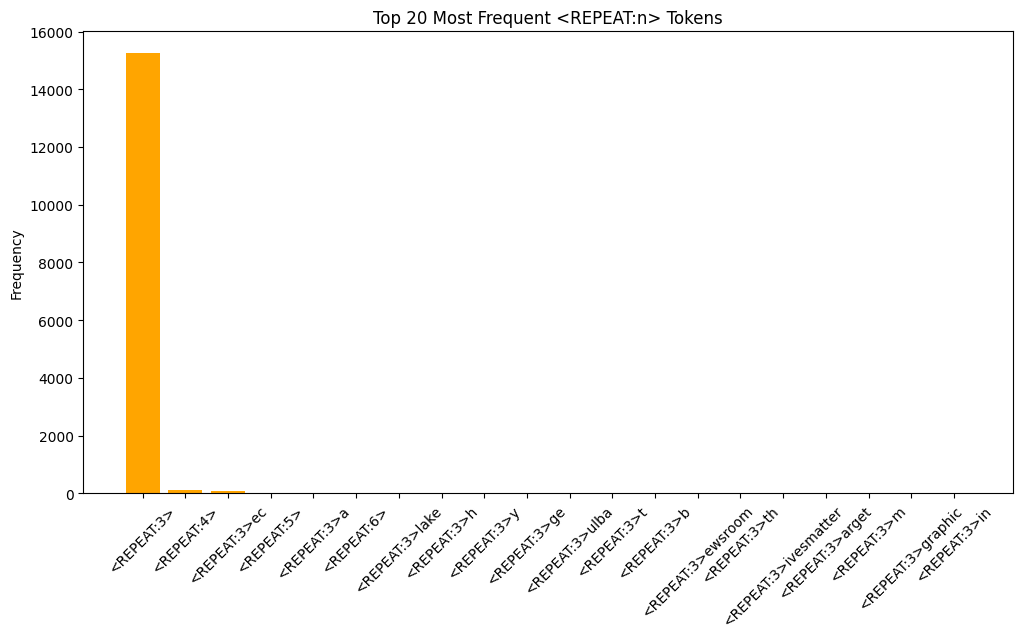

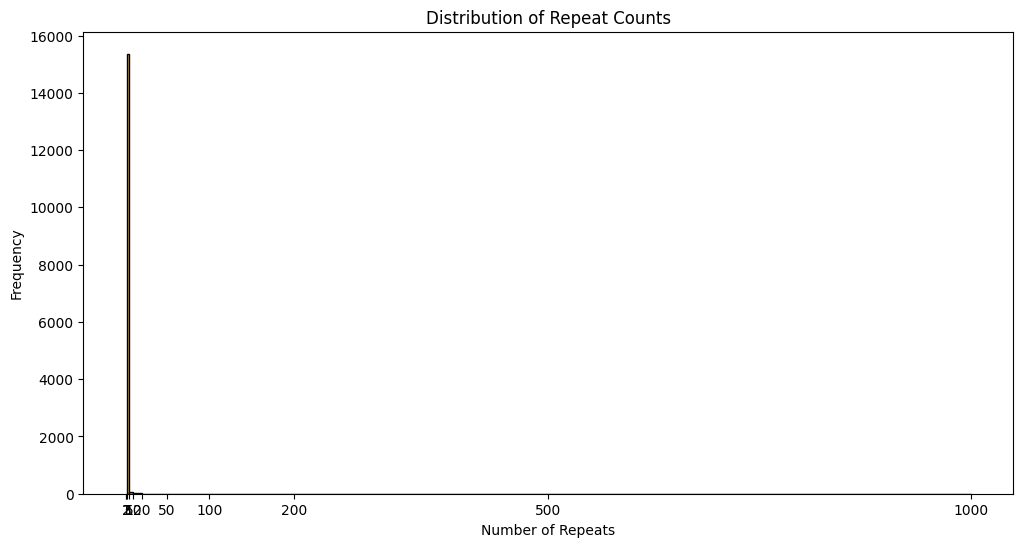

In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import re

# Assuming all_tokens already exists
# Replace this with your actual token list
# all_tokens = [...]

# Extract repeat tokens
repeat_tokens = [tok for tok in all_tokens if tok.startswith('<REPEAT:')]

# Count them
repeat_counts = Counter(repeat_tokens)

if repeat_counts:
    # ✅ Option 1: Bar chart of Top 20 most frequent repeat tokens
    top_k = 20
    common_repeats = repeat_counts.most_common(top_k)
    repeat_words, repeat_freqs = zip(*common_repeats)

    plt.figure(figsize=(12,6))
    plt.bar(repeat_words, repeat_freqs, color='orange')
    plt.title(f'Top {top_k} Most Frequent <REPEAT:n> Tokens')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.show()

    # ✅ Option 2: Histogram grouping repeat counts into bins
    repeat_numbers = []
    for tok in repeat_tokens:
        match = re.match(r'<REPEAT:(\d+)>$', tok)
        if match:
            repeat_numbers.append(int(match.group(1)))

    if repeat_numbers:
        bins = [1, 2, 3, 5, 10, 20, 50, 100, 200, 500, 1000]

        plt.figure(figsize=(12,6))
        plt.hist(repeat_numbers, bins=bins, color='orange', edgecolor='black')
        plt.title('Distribution of Repeat Counts')
        plt.xlabel('Number of Repeats')
        plt.ylabel('Frequency')
        plt.xticks(bins)
        plt.show()
    else:
        print("No well-formed <REPEAT:n> tokens found.")

else:
    print('No <REPEAT:n> tokens found in the corpus.')

Naive Bayes Metrics:
 {'accuracy': 0.9328507795100223, 'precision': 0.9348448687350835, 'recall': 0.922298092771368, 'f1_score': 0.9285290980206234}

SVM Metrics:
 {'accuracy': 0.994097995545657, 'precision': 0.993876589731512, 'recall': 0.9936425712267483, 'f1_score': 0.9937595667019898}


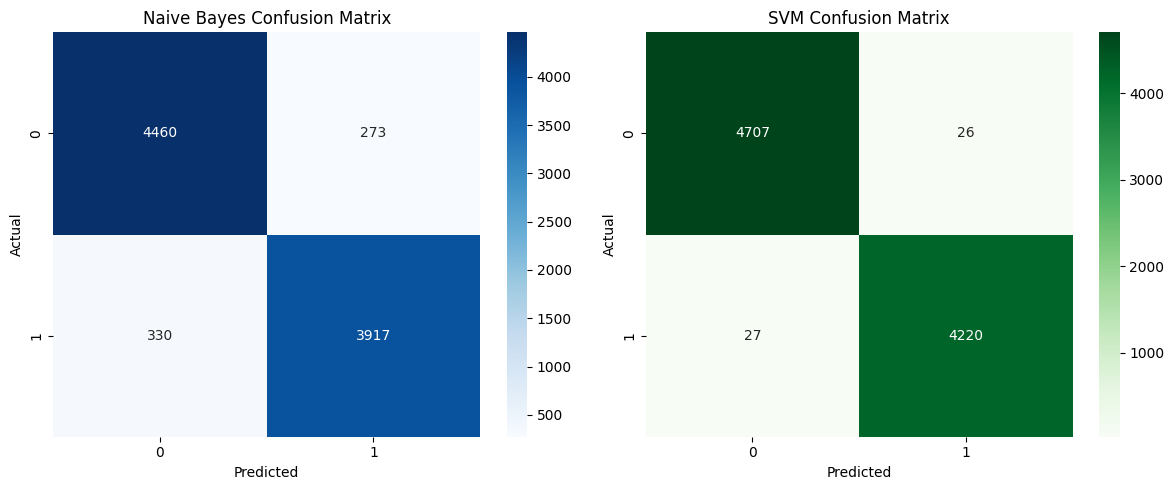

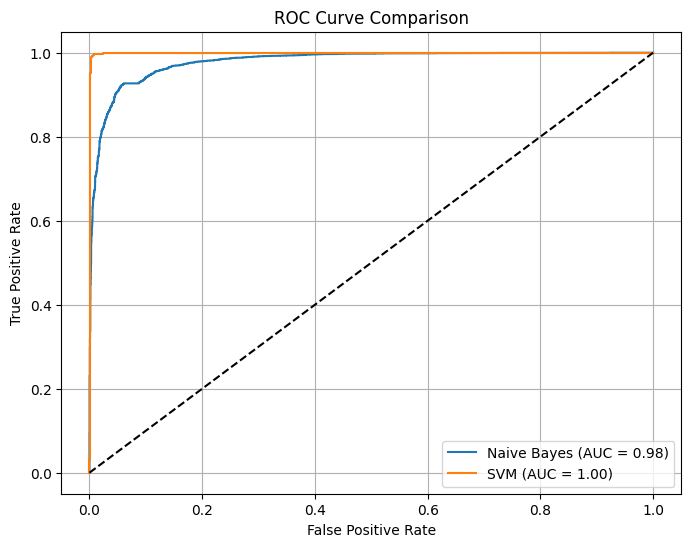

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming your DataFrame is named df and has 'text' and 'label' columns
# Example:
# df = pd.read_csv("news.csv")

# Feature Extraction (if you haven't yet)
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(df['text'].values)
y = df['label'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize models
nb_clf = MultinomialNB()
svm_clf = LinearSVC()

# Train models
nb_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

# Predictions
nb_preds = nb_clf.predict(X_test)
svm_preds = svm_clf.predict(X_test)

# Probability scores for ROC
nb_probs = nb_clf.predict_proba(X_test)[:, 1]
svm_scores = svm_clf.decision_function(X_test)

# 📊 Classification Metrics
def get_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

metrics = {
    'Naive Bayes': get_metrics(y_test, nb_preds),
    'SVM': get_metrics(y_test, svm_preds)
}

print("Naive Bayes Metrics:\n", metrics['Naive Bayes'])
print("\nSVM Metrics:\n", metrics['SVM'])


# 📊 Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Naive Bayes
nb_cm = confusion_matrix(y_test, nb_preds)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Naive Bayes Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# SVM
svm_cm = confusion_matrix(y_test, svm_preds)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('SVM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# 📈 ROC Curves
# ROC Curve data
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_scores)

# AUC scores
nb_auc = auc(nb_fpr, nb_tpr)
svm_auc = auc(svm_fpr, svm_tpr)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()
